In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dsp import DSP

## Init Radar

In [4]:
sdr = adi.Pluto(uri="ip:192.168.2.1")

## Configuration
### Range FFT
Range Resolution (delta_r) = c/2*bw 
|Symbol|Desc.|
|---|---|
|c|Speed of Light|
|bw|Signal bandwidth|

In [ ]:
c = scipy.constants.c  # speed of light
f0 = int(2.4e9)

In [6]:
# Configure SDR settings
sdr.rx_rf_bandwidth = int(20e6)  # Set receive bandwidth to 10 MHz
sdr.rx_lo = int(2.4e9)         # Set the LO (center frequency) to 2.4 GHz
sdr.rx_hardwaregain = 40       # Set the receiver gain
sdr.sample_rate = 1000000      # Set the sample rate to 1 MSPS
sdr.rx_buffer_size = 1024      # Number of samples per receive call
c = scipy.constants.c
delta_r = c / (2*sdr.rx_rf_bandwidth) # Range resolution

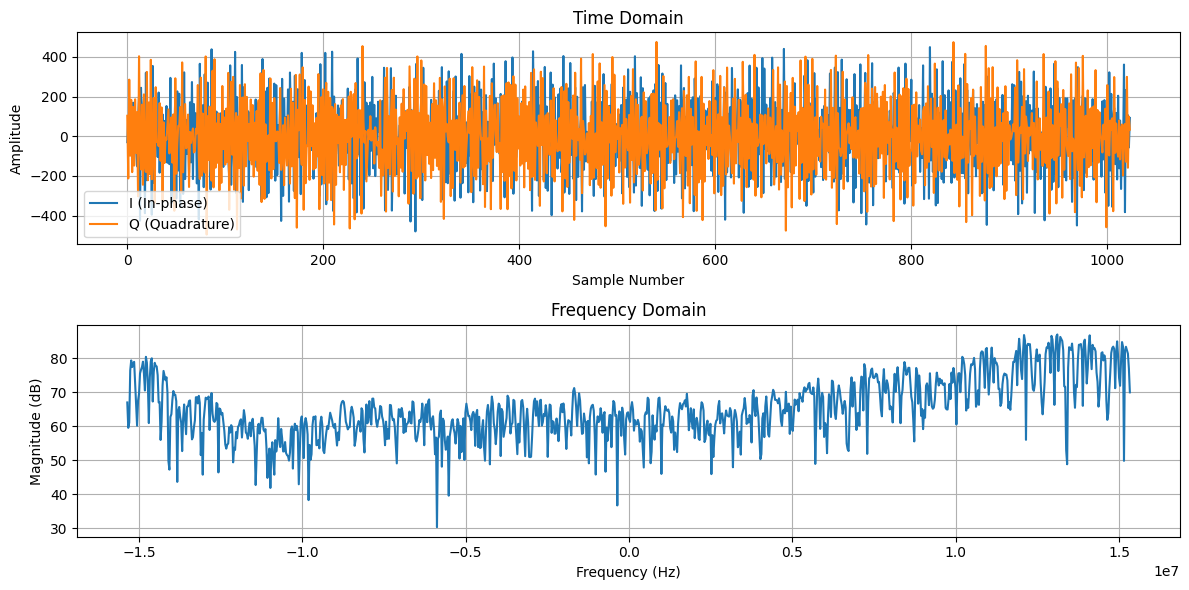

In [5]:
# Receive data
data = sdr.rx()

# Plotting the received data in the time domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.real(data), label="I (In-phase)")
plt.plot(np.imag(data), label="Q (Quadrature)")
plt.title("Time Domain")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()


# Range FFT
dsp_processor = DSP(num_samples=sdr.rx_buffer_size)
data_fft = dsp_processor.calc_range_fft(data)

# Frequency domain analysis using FFT
# data_fft = np.fft.fftshift(np.fft.fft(data))
freqs = np.fft.fftshift(np.fft.fftfreq(len(data), 1 / sdr.sample_rate))

plt.subplot(2, 1, 2)
plt.plot(freqs, 20 * np.log10(np.abs(data_fft)))
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Cleanup
sdr.rx_destroy_buffer()  # Free up the buffer


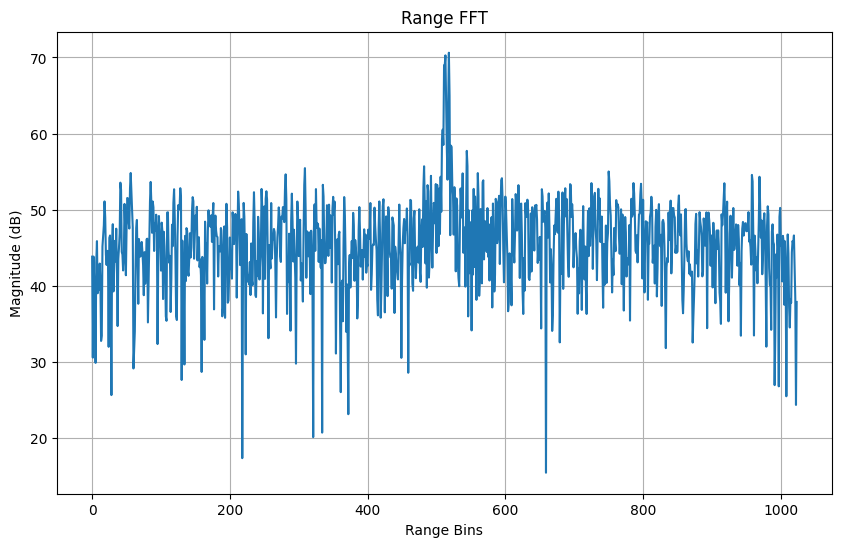

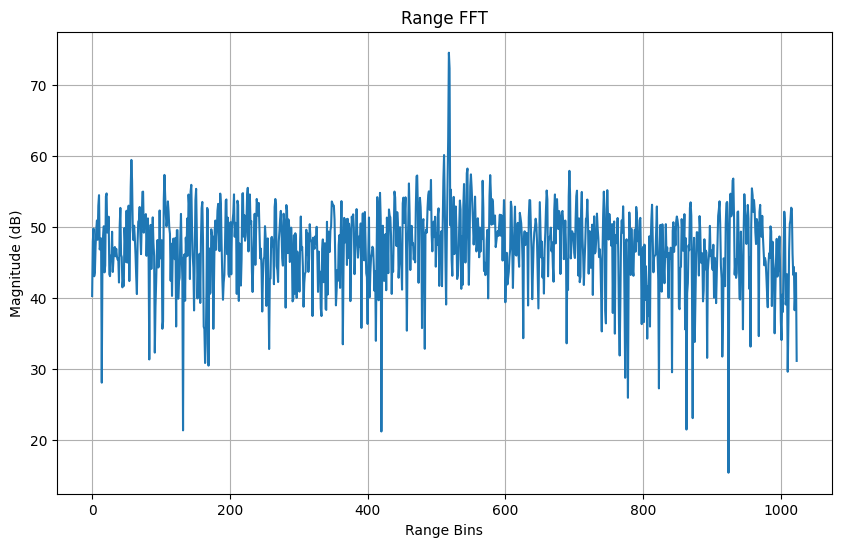

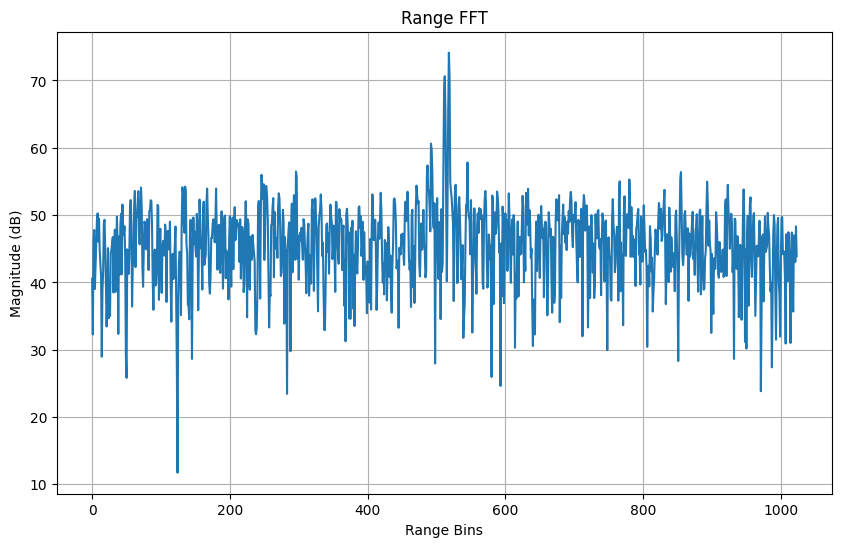

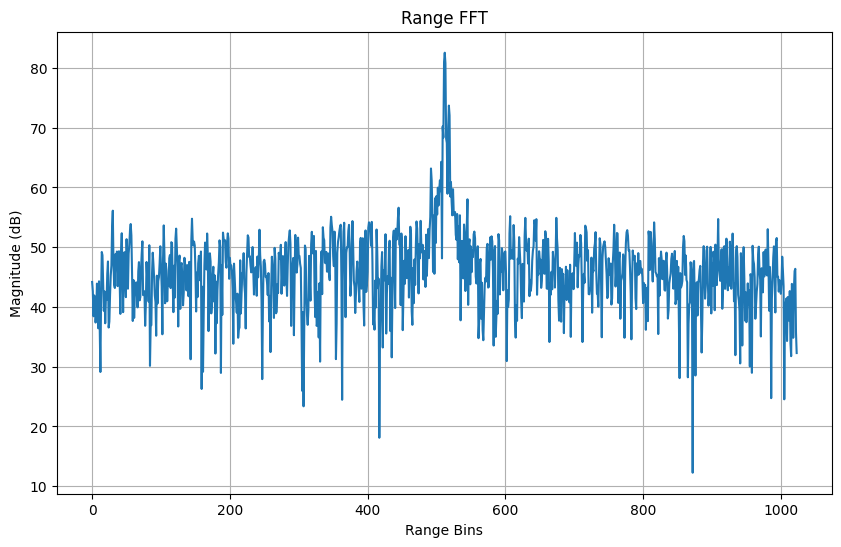

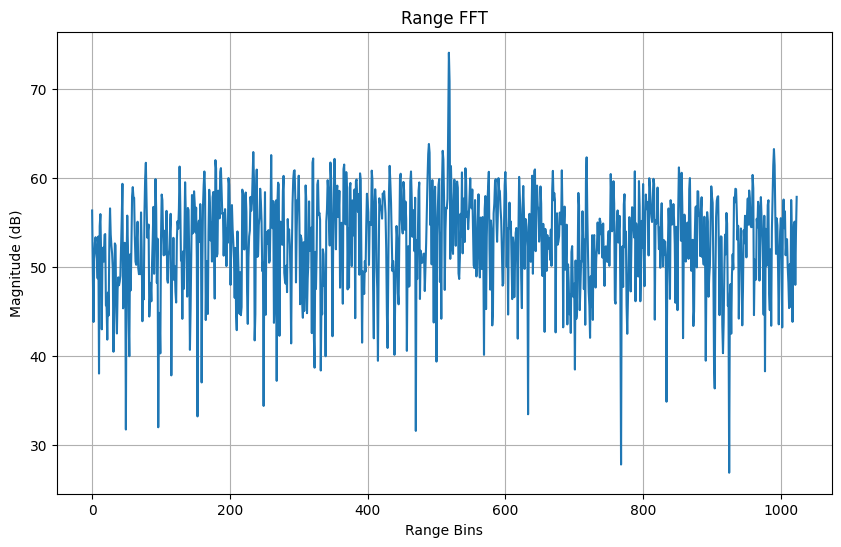

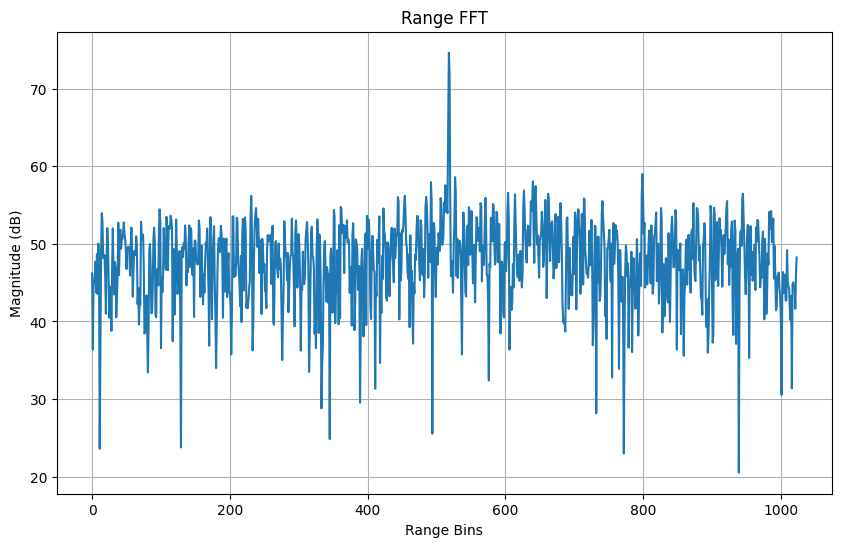

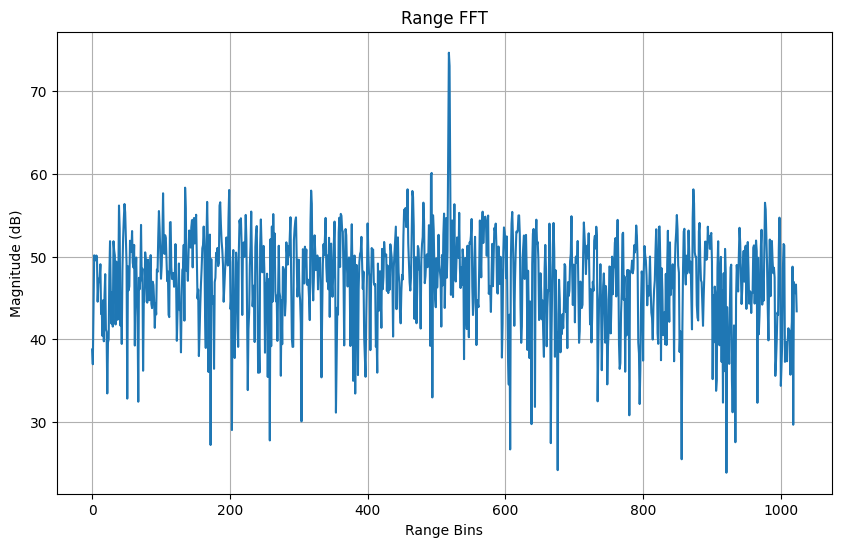

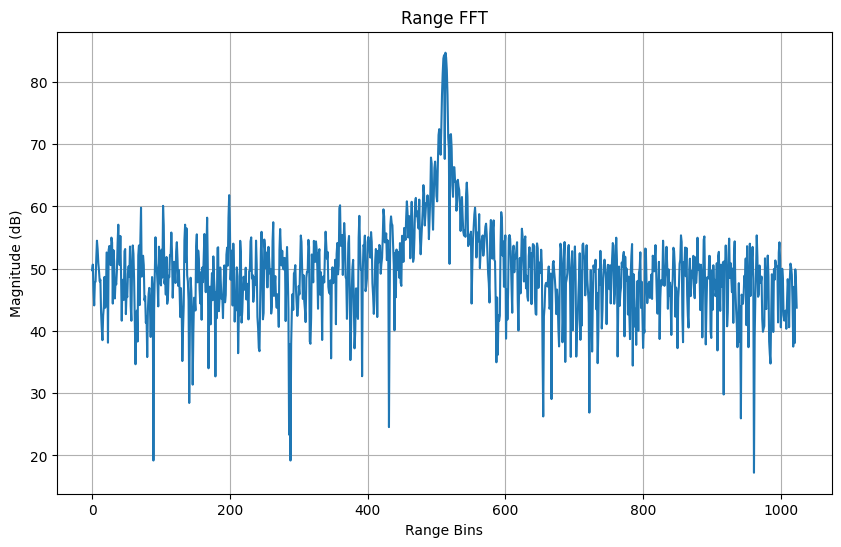

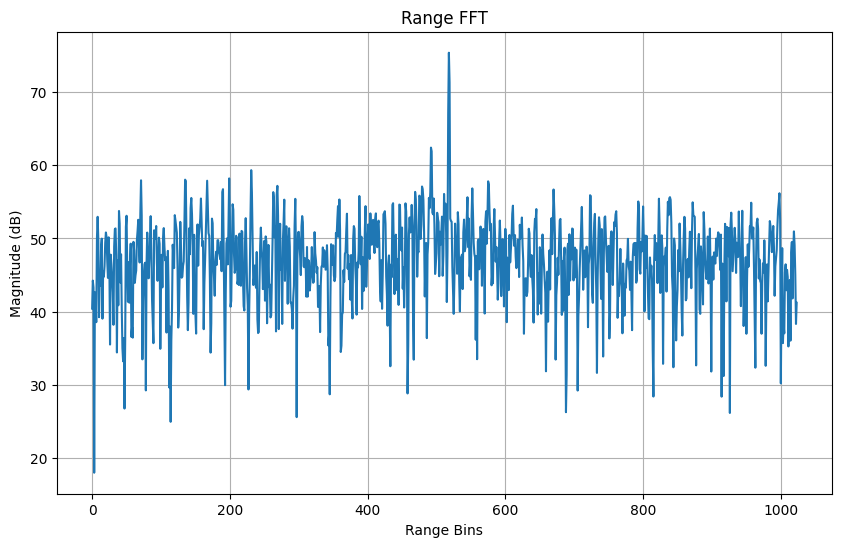

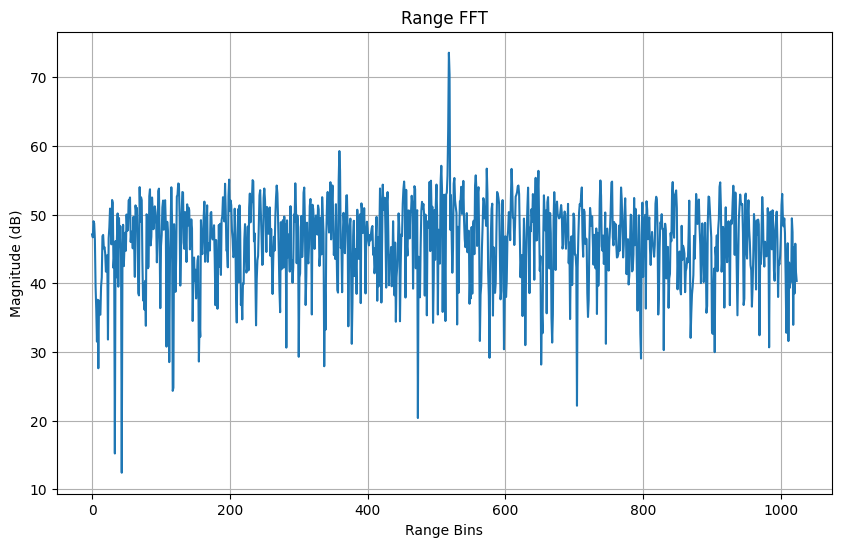

In [7]:
import adi  # ADALM-PLUTO library
import numpy as np
import matplotlib.pyplot as plt


# Apply range FFT processing
def calc_range_fft(rx_data, range_win, spc):
    """
    Calculate the range FFT for a single Rx channel.
    :param rx_data: 1D array of received samples from the single channel.
    :param range_win: Window function applied to the samples.
    :param spc: Number of samples per chirp.
    :return: Range FFT array.
    """
    rx_data_nodc = rx_data - np.mean(rx_data)  # Mean removal to eliminate DC offset
    rx_data_windowed = rx_data_nodc * range_win  # Apply window function
    rx_data_range = np.fft.fftshift(np.fft.fft(rx_data_windowed, spc))  # Range FFT
    rx_data_range = np.abs(rx_data_range)  # Magnitude of FFT result
    return rx_data_range

for _ in range(10):
    # Retrieve data (single frame or chirp)
    data = sdr.rx()

    # Define range FFT parameters
    spc = sdr.rx_buffer_size  # Number of samples in the chirp
    range_win = np.hanning(spc)  # Example range window (Hanning)
    # Perform range FFT
    range_fft_result = calc_range_fft(data, range_win, spc)

    # Plotting the Range FFT
    plt.figure(figsize=(10, 6))
    plt.plot(20 * np.log10(range_fft_result))
    plt.title("Range FFT")
    plt.xlabel("Range Bins")
    plt.ylabel("Magnitude (dB)")
    plt.grid()
    plt.show()


In [28]:
#!/usr/bin/env python3
# Import necessary libraries
import adi
import sys
import time
import numpy as np
import pyqtgraph as pg
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QGridLayout, QLabel, QCheckBox, QPushButton, QSlider
from pyqtgraph.Qt import QtCore, QtGui


In [70]:
# Initialize PlutoSDR
sdr = adi.Pluto(uri="ip:192.168.2.1")

In [62]:
N_chirp

2999

In [71]:
import scipy.constants


sample_rate = int(30e6)
center_freq = 2.4e9
signal_freq = 2.4e9
bw = 100e3
fft_size = 1024
plot_freq = 200e3  # x-axis frequency range to plot ±100 kHz
buffer_length = 32768

# Configure SDR
# Transmit Parameters
sdr.tx_lo = int(2.4e9)
sdr.tx_hardwaregain_chan0 = -20  # Adjust based on desired signal strength

# Receive Parameterss
sdr.sample_rate = int(sample_rate)
sdr.rx_lo = int(center_freq)
sdr.rx_buffer_size = int(buffer_length)
sdr.gain_control_mode_chan0 = "manual"
sdr.rx_hardwaregain_chan0 = int(40)


# Generate a transmit waveform
fs = int(sdr.sample_rate)

# FMCW Parameters
N = int(sdr.rx_buffer_size)
duration = 0.1e-3 # Chirp duration of 0.1ms
fc = int(signal_freq / (fs / N)) * (fs / N)
ts = 1 / float(fs)
N_chirp = int(duration * fs)
t = np.arange(0, N_chirp * ts, ts)
f_base_start = -bw  # e.g., -100kHz
f_base_stop = bw    # +100kHz

# t = np.arange(0, N * ts, ts)

chirp_signal = np.exp(1j * 2 * np.pi * (f_base_start * t + 0.5 * (f_base_stop - f_base_start) / duration * t**2))
chirp_padded = np.zeros(buffer_length, dtype=np.complex64)
chirp_padded[:len(chirp_signal)] = chirp_signal.astype(np.complex64)
# For single tone genration
# i = np.cos(2 * np.pi * t * fc) * 2 ** 14
# q = np.sin(2 * np.pi * t * fc) * 2 ** 14
# iq = i + 1j * q  # Amplitude of 1

# Transmit the signal
sdr.tx_cyclic_buffer = True  # Enable cyclic transmission
sdr.tx(chirp_padded)


# Constants for range calculation (using a default bandwidth)
c = scipy.constants.speed_of_light  # Speed of light
# ramp_time = 0.5e3  # Ramp time in us
ramp_time_s = duration  # Convert to seconds
slope = (2 * bw) / ramp_time_s
# dist = (np.linspace(-fs / 2, fs / 2, fft_size) - signal_freq) * c / (2 * slope)
freq = np.fft.fftshift(np.fft.fftfreq(sdr.rx_buffer_size, 1 / fs))
dist = (freq - signal_freq) * c / (2 * slope)

plot_dist = False

class Window(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Interactive FFT for PlutoSDR")
        self.setGeometry(0, 0, 400, 400)
        self.setWindowState(QtCore.Qt.WindowMaximized)
        self.num_rows = 12
        self.UiComponents()
        self.show()

    # Set up the GUI components
    def UiComponents(self):
        widget = QWidget()
        global layout, signal_freq
        layout = QGridLayout()

        control_label = QLabel("PlutoSDR FMCW Radar Demo")
        font = control_label.font()
        font.setPointSize(24)
        control_label.setFont(font)
        layout.addWidget(control_label, 0, 0, 1, 2)

        # Check box for toggling distance view
        self.x_axis_check = QCheckBox("Convert to Distance")
        font.setPointSize(10)
        self.x_axis_check.setFont(font)
        self.x_axis_check.stateChanged.connect(self.change_x_axis)
        layout.addWidget(self.x_axis_check, 2, 0)

        # FFT plot setup
        self.fft_plot = pg.plot()
        self.fft_plot.setMinimumWidth(600)
        self.fft_curve = self.fft_plot.plot(pen={'color':'y', 'width':2})
        title_style = {"size": "20pt"}
        label_style = {"color": "#FFF", "font-size": "14pt"}
        self.fft_plot.setLabel("bottom", text="Frequency", units="Hz", **label_style)
        self.fft_plot.setLabel("left", text="Magnitude", units="dB", **label_style)
        self.fft_plot.setTitle("Received Signal - Frequency Spectrum", **title_style)
        layout.addWidget(self.fft_plot, 0, 2, self.num_rows, 1)
        self.fft_plot.setYRange(-60, 0)
        self.fft_plot.setXRange(-plot_freq / 2, plot_freq / 2)


        widget.setLayout(layout)
        self.setCentralWidget(widget)

    def change_x_axis(self, state):
        """ Toggles between showing frequency and range for the x-axis """
        global plot_dist
        label_style = {"color": "#FFF", "font-size": "14pt"}
        plot_dist = state == QtCore.Qt.Checked
        if plot_dist:
            range_x = plot_freq * c / (2 * slope)
            self.fft_plot.setXRange(0, range_x)
            self.fft_plot.setLabel("bottom", text="Distance", units="m", **label_style)
        else:
            self.fft_plot.setXRange(signal_freq, signal_freq+plot_freq)
            self.fft_plot.setLabel("bottom", text="Frequency", units="Hz", **label_style)

# Start PyQt5 app
App = QApplication(sys.argv)
win = Window()
index = 0

def update():
    """ Updates the FFT in the window """
    global index, plot_dist, dist
    label_style = {"color": "#FFF", "font-size": "14pt"}

    # Receive data from PlutoSDR
    data = sdr.rx()
    win_funct = np.blackman(len(data))
    y = data * win_funct
    sp = np.fft.fftshift(np.fft.fft(y))
    s_mag = np.abs(sp) / np.sum(win_funct)
    s_mag = np.maximum(s_mag, 10 ** (-15))
    s_dbfs = 20 * np.log10(s_mag / np.max(s_mag))

    if plot_dist:
        win.fft_curve.setData(dist, s_dbfs)
        win.fft_plot.setLabel("bottom", text="Distance", units="m", **label_style)
    else:
        # freq = np.fft.fftshift(np.fft.fftfreq(len(data), 1 / fs))
        win.fft_curve.setData(freq, s_dbfs)
        win.fft_plot.setLabel("bottom", text="Frequency", units="Hz", **label_style)

    if index == 1:
        win.fft_plot.enableAutoRange("xy", False)
    index += 1

timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(0)

# Start the app
sys.exit(App.exec())


SystemExit: 0

c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
import numpy as np
samp_rate = 1e6
bw = 100e3
duration = 20e-6
total_samples = samp_rate * duration
n_chirp = int(total_samples // 2)
n_idle = int(total_samples - n_chirp)
chirp = np.linspace(0, 1.0, n_chirp, dtype=np.float32)
idle = np.zeros(n_idle, dtype=np.float32)
frame = np.concatenate([chirp, idle])

In [10]:
frame

array([0.        , 0.11111111, 0.22222222, 0.33333334, 0.44444445,
       0.5555556 , 0.6666667 , 0.7777778 , 0.8888889 , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [1]:
import numpy as np
import scipy.constants
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QGridLayout, QWidget, QLabel, QCheckBox
from PyQt5 import QtCore
import pyqtgraph as pg
import adi

# === PlutoSDR Configuration ===
sdr = adi.Pluto(uri="ip:192.168.2.1")

sample_rate = int(1e6)
center_freq = int(2.4e9)
signal_freq = int(2.4e9)
bw = 100e3
fft_size = 1024
plot_freq = 200e3
buffer_length = 4096

# Transmit Parameters
sdr.tx_lo = center_freq
sdr.tx_hardwaregain_chan0 = -20

# Receive Parameters
sdr.sample_rate = sample_rate
sdr.rx_lo = center_freq
sdr.rx_buffer_size = buffer_length
sdr.gain_control_mode_chan0 = "manual"
sdr.rx_hardwaregain_chan0 = 40

# === FMCW Chirp Generation ===
fs = sample_rate
duration = 0.1e-3
ts = 1 / fs
N_chirp = int(duration * fs)
t = np.arange(0, N_chirp * ts, ts)
f_base_start = -bw
f_base_stop = bw
chirp_signal = np.exp(1j * 2 * np.pi * (f_base_start * t + 0.5 * (f_base_stop - f_base_start) / duration * t**2))
chirp_signal = chirp_signal.astype(np.complex64)

# Pad to transmit buffer length
chirp_padded = np.zeros(buffer_length, dtype=np.complex64)
chirp_padded[:len(chirp_signal)] = chirp_signal

# Transmit
sdr.tx_cyclic_buffer = True
sdr.tx(chirp_padded)

# Constants
c = scipy.constants.speed_of_light
slope = (f_base_stop - f_base_start) / duration
freq = np.fft.fftshift(np.fft.fftfreq(buffer_length, 1 / fs))
dist = freq * c / (2 * slope)
plot_dist = False

# === PyQt GUI ===
class Window(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Interactive FMCW Radar Viewer")
        self.setGeometry(0, 0, 400, 400)
        self.setWindowState(QtCore.Qt.WindowMaximized)
        self.num_rows = 12
        self.UiComponents()
        self.show()

    def UiComponents(self):
        widget = QWidget()
        global layout
        layout = QGridLayout()

        title_style = {"size": "20pt"}
        label_style = {"color": "#FFF", "font-size": "14pt"}

        # Title
        control_label = QLabel("PlutoSDR FMCW Radar Demo")
        font = control_label.font()
        font.setPointSize(24)
        control_label.setFont(font)
        layout.addWidget(control_label, 0, 0, 1, 2)

        # Checkbox for axis
        self.x_axis_check = QCheckBox("Convert to Distance")
        font.setPointSize(10)
        self.x_axis_check.setFont(font)
        self.x_axis_check.stateChanged.connect(self.change_x_axis)
        layout.addWidget(self.x_axis_check, 2, 0)

        # --- FFT Plot ---
        self.fft_plot = pg.PlotWidget()
        self.fft_curve = self.fft_plot.plot(pen={'color': 'y', 'width': 2})
        self.fft_plot.setMinimumWidth(600)
        self.fft_plot.setYRange(-60, 0)
        self.fft_plot.setXRange(-plot_freq / 2, plot_freq / 2)
        self.fft_plot.setTitle("Frequency Spectrum", **title_style)
        self.fft_plot.setLabel("bottom", "Frequency", units="Hz", **label_style)
        self.fft_plot.setLabel("left", "Magnitude", units="dB", **label_style)
        layout.addWidget(self.fft_plot, 0, 2, self.num_rows // 3, 1)

        # --- Time Plot ---
        self.time_plot = pg.PlotWidget()
        self.time_curve = self.time_plot.plot(pen='c')
        self.time_plot.setTitle("Time Domain (Real Part)", **title_style)
        self.time_plot.setLabel("bottom", "Sample", **label_style)
        self.time_plot.setLabel("left", "Amplitude", **label_style)
        layout.addWidget(self.time_plot, self.num_rows // 3, 2, self.num_rows // 3, 1)

        # --- IQ Plot ---
        self.iq_plot = pg.PlotWidget()
        self.iq_curve = self.iq_plot.plot(pen=None, symbol='o', symbolSize=3, symbolBrush='m')
        self.iq_plot.setTitle("IQ Plot (Complex Plane)", **title_style)
        self.iq_plot.setLabel("bottom", "In-phase (I)", **label_style)
        self.iq_plot.setLabel("left", "Quadrature (Q)", **label_style)
        layout.addWidget(self.iq_plot, 2 * self.num_rows // 3, 2, self.num_rows // 3, 1)

        widget.setLayout(layout)
        self.setCentralWidget(widget)

    def change_x_axis(self, state):
        global plot_dist
        label_style = {"color": "#FFF", "font-size": "14pt"}
        plot_dist = state == QtCore.Qt.Checked
        if plot_dist:
            max_dist = plot_freq * c / (2 * slope)
            self.fft_plot.setXRange(0, max_dist)
            self.fft_plot.setLabel("bottom", "Distance", units="m", **label_style)
        else:
            self.fft_plot.setXRange(-plot_freq / 2, plot_freq / 2)
            self.fft_plot.setLabel("bottom", "Frequency", units="Hz", **label_style)

# === App Init ===
App = QApplication(sys.argv)
win = Window()
index = 0

def update():
    """ Live data update from PlutoSDR """
    global index, plot_dist, dist

    data = sdr.rx()
    win_funct = np.blackman(len(data))
    y = data * win_funct
    sp = np.fft.fftshift(np.fft.fft(y))
    s_mag = np.abs(sp) / np.sum(win_funct)
    s_mag = np.maximum(s_mag, 10 ** (-15))
    s_dbfs = 20 * np.log10(s_mag / np.max(s_mag))

    # Frequency or Distance
    if plot_dist:
        win.fft_curve.setData(dist, s_dbfs)
    else:
        win.fft_curve.setData(freq, s_dbfs)

    # Time domain (real)
    win.time_curve.setData(np.real(data))

    # Complex IQ plot
    win.iq_curve.setData(np.real(data), np.imag(data))

    if index == 1:
        win.fft_plot.enableAutoRange("xy", False)
        win.time_plot.enableAutoRange("xy", True)
        win.iq_plot.enableAutoRange("xy", True)
    index += 1

# Timer
timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(0)

# Run App
sys.exit(App.exec())


SystemExit: 0

c:\Users\atsy_\Desktop\cp5105-project\.venv\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# has to be adjusted to settings
fc = 60e9
wave_length = 3e8/fc
chirp_count = 64
frame_count = 64
chirp_time = 3915500*1e-10
frame_time_short = chirp_time * chirp_count
frame_rate = 20 # in Hz
frame_time_long = 64/frame_rate
bandwidth = 5e9
range_bin_width = 3e8/(2*bandwidth)
print('frame_time_short: {:.2f}ms'.format(frame_time_short*1000),
      'frame_time_long: {:.2f}s'.format(frame_time_long),
      'velocity_res_short = {:.3f}cm/s'.format(100*wave_length/(2*frame_time_short)),
      'velocity_res_long = {:.3f}cm/s'.format(100*wave_length/(2*frame_time_long)),
      sep = '\n')
velocity_ticks_short = np.arange(chirp_count) * wave_length/(2*frame_time_short)
velocity_ticks_short = velocity_ticks_short - velocity_ticks_short.max()/2

velocity_ticks_long = np.arange(frame_count) * wave_length/(2*frame_time_long)
velocity_ticks_long = velocity_ticks_long - velocity_ticks_long.max()/2

range_ticks = np.arange(128)*range_bin_width



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

c = scipy.constants.speed_of_light
fc = 2.4e9
bw = 20e6  # Bandwidth in Hz
if_max = 0.9 * 61.44e6  # 0.9 * ADC_sampling
range_resolution = c / (2 * bw)
ramp_time = 30e6  # Ramp time Mhz/us
ramp_time_s = ramp_time * 1e6 * 1e6 # Convert to seconds
 # Ramp time Hhz/s
total_chirp_time = bw / ramp_time # chirp_time + idle_time

print(total_chirp_time * 10e6)

6666666.666666666


In [25]:
print(f"range res: {range_resolution}, range_max: {range_max}")

range res: 7.49481145, range_max: 0.0002762887292928


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

c = scipy.constants.speed_of_light
fc = 1e3
bw = 20e6  # Bandwidth in Hz
range_max = (20e6 * c) / (2 * bw) 
range_resolution = c / (2 * bw)
total_chirp_time = bw / ramp_time # chirp_time + idle_time

ramp_time = 30e6  # Ramp time Mhz/us
ramp_time_s = ramp_time / 1e6  # Convert to seconds
slope = bw / ramp_time_s
# dist = (np.linspace(-fs / 2, fs / 2, fft_size) - signal_freq) * c / (2 * slope)
fs = 2.4e6

# ramp_up_time   = 0.2        # Duration of the ramp-up (seconds)
idle_time      = ramp_time_s  # Duration of idle region (seconds)
peak_amplitude = 1.0        # Final amplitude at end of ramp

# -------------------------------------------------------
# 2) Compute number of samples for ramp-up and idle time
# -------------------------------------------------------
ramp_up_samples = int(ramp_time_s * fs)
idle_samples    = int(idle_time * fs)

# ------------------------------------------------
# 3) Generate waveforms for each segment
# ------------------------------------------------
# Ramp-up from 0 to peak_amplitude linearly
ramp_up = np.linspace(0, peak_amplitude, ramp_up_samples, endpoint=False)

# Idle region of constant 0 amplitude
idle = np.zeros(idle_samples)

# -----------------------------------------
# 4) Concatenate arrays into one waveform
# -----------------------------------------
custom_wave = np.concatenate([ramp_up, idle])

# ---------------------------------------
# 5) Visualize the waveform in matplotlib
# ---------------------------------------
time_axis = np.arange(len(custom_wave)) / fs  # time in seconds

plt.figure(figsize=(8, 4))
plt.plot(time_axis, custom_wave, label='Ramp+Idle Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Custom Ramp + Idle Waveform')
# plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------
# 6) This 'custom_wave' can be used in GNURadio:
#    - Save 'custom_wave' as an array or .npy file 
#      or directly embed in a Vector Source block
#    - Set "Repeat" to True if you want it looping
# ----------------------------------------------------

ValueError: Maximum allowed size exceeded

In [5]:
1/0.0005

2000.0